In [3]:
import pandas as pd
import numpy as np

# Fix random seed to make data reproducible
np.random.seed(42)

# number of samples
n = 50000

df = pd.DataFrame()

# Generate features
df['child_id'] = range(1, n+1)

df['age_months'] = np.random.randint(0, 60, n)

df['gender'] = np.random.randint(0, 2, n)

df['height_cm'] = np.round(np.random.normal(80, 10, n), 1)

df['weight_kg'] = np.round(np.random.normal(10, 2, n), 1)

df['mother_bmi'] = np.round(np.random.normal(20, 3, n), 1)

df['mother_height_cm'] = np.round(np.random.normal(155, 7, n), 1)

df['mother_anemia'] = np.random.randint(0, 2, n)

df['mother_education'] = np.random.randint(0, 4, n)

df['birth_weight'] = np.round(np.random.normal(2.8, 0.5, n), 1)

df['recent_illness'] = np.random.randint(0, 2, n)

df['immunization_status'] = np.random.randint(0, 2, n)

df['income_level'] = np.random.randint(0, 3, n)

df['residence'] = np.random.randint(0, 2, n)

df['family_size'] = np.random.randint(2, 8, n)

df['water_source'] = np.random.randint(0, 2, n)

df['sanitation'] = np.random.randint(0, 2, n)

df['exclusive_breastfeeding'] = np.random.randint(0, 2, n)

df['dietary_diversity'] = np.random.randint(0, 3, n)

# Create anthropometric indicators

df['underweight'] = (df['weight_kg'] < 8).astype(int)

df['stunted'] = (df['height_cm'] < 70).astype(int)

df['wasted'] = ((df['weight_kg'] / df['height_cm']) < 0.12).astype(int)

# Create malnutrition target

risk_score = (
    df['underweight'] * 3 +
    df['wasted'] * 2 +
    df['stunted'] * 2 +
    (df['mother_bmi'] < 18.5).astype(int) +
    (df['birth_weight'] < 2.5).astype(int) +
    df['dietary_diversity'] +
    df['income_level'] +
    df['recent_illness']
)

noise = np.random.normal(0, 0.5, n)

df['malnourished_final'] = ((risk_score + noise) >= 4).astype(int)

# Save file
df.to_csv("india_malnutrition_improved.csv", index=False)

print("Dataset generated successfully")

df.head()

Dataset generated successfully


,child_id,age_months,gender,height_cm,weight_kg,mother_bmi,mother_height_cm,mother_anemia,mother_education,birth_weight,...,residence,family_size,water_source,sanitation,exclusive_breastfeeding,dietary_diversity,underweight,stunted,wasted,malnourished_final
0,1,38,1,85.5,10.0,21.5,152.1,0,3,2.3,...,0,6,1,0,1,0,0,0,1,1
1,2,51,0,71.4,10.5,21.6,160.4,0,3,3.5,...,1,3,0,0,0,2,0,0,0,0
2,3,28,1,52.0,14.0,22.3,151.8,1,1,3.1,...,0,5,0,1,0,1,0,1,0,1
3,4,14,0,75.4,14.8,21.4,164.1,0,1,3.4,...,1,5,0,1,1,0,0,0,0,0
4,5,42,1,82.5,13.4,20.3,160.5,1,1,2.5,...,0,7,1,0,1,0,0,0,0,0


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_csv('india_malnutrition_improved.csv')

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [5]:
import numpy as np
np.random.seed(42)

# Anthropometric score (PRIMARY)
anthro_score = (
    df['underweight'] * 3 +
    df['wasted'] * 3 +
    df['stunted'] * 3 +
    (df['height_cm'] < df['height_cm'].median()).astype(int) * 1
)

# Risk factor score (SECONDARY)
risk_score = (
    (df['mother_bmi'] < 18.5).astype(int) * 2 +
    (df['birth_weight'] < 2.5).astype(int) * 2 +
    df['mother_anemia'] * 1 +
    df['recent_illness'] * 1 +
    df['dietary_diversity'] * 1 +
    df['sanitation'] * 1 +
    df['water_source'] * 1 +
    df['income_level'] * 1
)

# Combine both
total_score = anthro_score + risk_score

# Add small noise
noise = np.random.normal(0, 1, len(df))

# Final target
df['malnourished_final'] = ((total_score + noise) >= 5).astype(int)

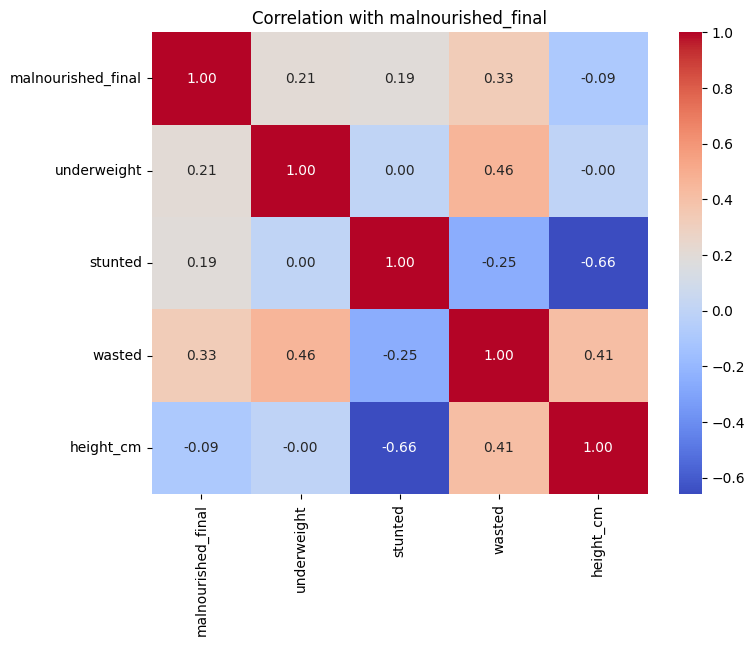

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_columns = [
    'malnourished_final',
    'underweight',
    'stunted',
    'wasted',
    'height_cm',
]

plt.figure(figsize=(8,6))

sns.heatmap(
    df[corr_columns].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)

plt.title("Correlation with malnourished_final")
plt.show()

In [7]:
X = df.drop([
    'child_id',
    'malnourished_final',
    'underweight',
    'stunted',
    'wasted'
], axis=1)

y = df['malnourished_final']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [9]:
print("Full Dataset Distribution:")
print(y.value_counts())

print("\nTraining Data Distribution (Before SMOTE):")
print(y_train.value_counts())


Full Dataset Distribution:
malnourished_final
1    40097
0     9903
Name: count, dtype: int64

Training Data Distribution (Before SMOTE):
malnourished_final
1    32078
0     7922
Name: count, dtype: int64


In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Training Data Distribution (After SMOTE):")
print(y_train_smote.value_counts())


Training Data Distribution (After SMOTE):
malnourished_final
1    32078
0    32078
Name: count, dtype: int64


In [11]:
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(
    xgb,
    param_grid,
    n_iter=15,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [12]:
import joblib

joblib.dump(best_model, "malnutrition_model.pkl")

['malnutrition_model.pkl']

In [13]:
import joblib
print("Model saved successfully")

Model saved successfully


In [14]:
y_prob = best_model.predict_proba(X_test)[:,1]

y_pred = (y_prob >= 0.45).astype(int)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9073
Precision: 0.9185552407932012
Recall: 0.9704451926674149
F1 score: 0.9437875204657086

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.65      0.74      1981
           1       0.92      0.97      0.94      8019

    accuracy                           0.91     10000
   macro avg       0.88      0.81      0.84     10000
weighted avg       0.90      0.91      0.90     10000



In [16]:
print(X.columns)

Index(['age_months', 'gender', 'height_cm', 'weight_kg', 'mother_bmi',
       'mother_height_cm', 'mother_anemia', 'mother_education', 'birth_weight',
       'recent_illness', 'immunization_status', 'income_level', 'residence',
       'family_size', 'water_source', 'sanitation', 'exclusive_breastfeeding',
       'dietary_diversity'],
      dtype='object')


In [17]:

# INFERENCE FUNCTION: Predict malnutrition from manual input

def predict_malnutrition_manual():

    # Enter feature values manually (example values)

    age_months = float(input("Enter age in months: "))
    gender = int(input("Enter gender (0 = Female, 1 = Male): "))
    height_cm = float(input("Enter height (cm): "))
    weight_kg = float(input("Enter weight (kg): "))
    mother_bmi = float(input("Enter mother BMI: "))
    mother_height_cm = float(input("Enter mother height (cm): "))
    mother_anemia = int(input("Enter mother anemia (0 = No, 1 = Yes): "))
    mother_education = int(input("Enter mother education (0 = No Education, 1 = Primary, 2 = Secondary, 3 = Higher): "))
    birth_weight = float(input("Enter birth weight (kg): "))
    recent_illness = int(input("Enter recent illness (0 = No, 1 = Yes): "))
    immunization_status = int(input("Enter immunization status (0 = Incomplete, 1 = Complete): "))
    income_level = int(input("Enter income level (0 = High, 1 = Low, 2 = Middle): "))
    residence = int(input("Enter residence (0 = Rural, 1 = Urban): "))
    family_size = int(input("Enter family size: "))
    water_source = int(input("Enter water source (0 = Safe, 1 = Unsafe): "))
    sanitation = int(input("Enter sanitation (0 = Improved, 1 = Unimproved): "))
    exclusive_breastfeeding = int(input("Enter exclusive breastfeeding (0 = No, 1 = Yes): "))
    dietary_diversity = int(input("Enter dietary diversity (0 = Low, 1 = Medium, 2 = High): "))

    # Create dataframe with same feature order as X
    input_data = pd.DataFrame([[age_months, gender, height_cm, weight_kg,
                                mother_bmi, mother_height_cm, mother_anemia,
                                mother_education, birth_weight, recent_illness,
                                immunization_status, income_level, residence,
                                family_size, water_source, sanitation,
                                exclusive_breastfeeding, dietary_diversity
                               ]], columns=X.columns)

    # Predict
    prediction = best_model.predict(input_data)[0]

    # Output result
    if prediction == 1:
        print("\nResult: Child is MALNOURISHED")
    else:
        print("\nResult: Child is NOT MALNOURISHED")


# Run inference
predict_malnutrition_manual()
# print("Prediction:", loaded_model.predict(high_risk_child)[0]) # This line caused the error and is commented out

Enter age in months: 12
Enter gender (0 = Female, 1 = Male): 1
Enter height (cm): 78
Enter weight (kg): 9.2
Enter mother BMI: 17
Enter mother height (cm): 167
Enter mother anemia (0 = No, 1 = Yes): 1
Enter mother education (0 = No Education, 1 = Primary, 2 = Secondary, 3 = Higher): 1
Enter birth weight (kg): 3.2
Enter recent illness (0 = No, 1 = Yes): 1
Enter immunization status (0 = Incomplete, 1 = Complete): 1
Enter income level (0 = High, 1 = Low, 2 = Middle): 1
Enter residence (0 = Rural, 1 = Urban): 1
Enter family size: 8
Enter water source (0 = Safe, 1 = Unsafe): 1
Enter sanitation (0 = Improved, 1 = Unimproved): 1
Enter exclusive breastfeeding (0 = No, 1 = Yes): 1
Enter dietary diversity (0 = Low, 1 = Medium, 2 = High): 1

Result: Child is MALNOURISHED


In [19]:
# INFERENCE FUNCTION: Predict malnutrition from manual input

def predict_malnutrition_manual():

    # Enter feature values manually (example values)

    age_months = float(input("Enter age in months: "))
    gender = int(input("Enter gender (0 = Female, 1 = Male): "))
    height_cm = float(input("Enter height (cm): "))
    weight_kg = float(input("Enter weight (kg): "))
    mother_bmi = float(input("Enter mother BMI: "))
    mother_height_cm = float(input("Enter mother height (cm): "))
    mother_anemia = int(input("Enter mother anemia (0 = No, 1 = Yes): "))
    mother_education = int(input("Enter mother education (0 = No Education, 1 = Primary, 2 = Secondary, 3 = Higher): "))
    birth_weight = float(input("Enter birth weight (kg): "))
    recent_illness = int(input("Enter recent illness (0 = No, 1 = Yes): "))
    immunization_status = int(input("Enter immunization status (0 = Incomplete, 1 = Complete): "))
    income_level = int(input("Enter income level (0 = High, 1 = Low, 2 = Middle): "))
    residence = int(input("Enter residence (0 = Rural, 1 = Urban): "))
    family_size = int(input("Enter family size: "))
    water_source = int(input("Enter water source (0 = Safe, 1 = Unsafe): "))
    sanitation = int(input("Enter sanitation (0 = Improved, 1 = Unimproved): "))
    exclusive_breastfeeding = int(input("Enter exclusive breastfeeding (0 = No, 1 = Yes): "))
    dietary_diversity = int(input("Enter dietary diversity (0 = Low, 1 = Medium, 2 = High): "))

    # Create dataframe with same feature order as X
    input_data = pd.DataFrame([[age_months, gender, height_cm, weight_kg,
                                mother_bmi, mother_height_cm, mother_anemia,
                                mother_education, birth_weight, recent_illness,
                                immunization_status, income_level, residence,
                                family_size, water_source, sanitation,
                                exclusive_breastfeeding, dietary_diversity
                               ]], columns=X.columns)

    # Predict
    prediction = best_model.predict(input_data)[0]

    # Output result
    if prediction == 1:
        print("\nResult: Child is MALNOURISHED")
    else:
        print("\nResult: Child is NOT MALNOURISHED")


# Run inference
predict_malnutrition_manual()
# print("Prediction:", loaded_model.predict(high_risk_child)[0]) # This line caused the error and is commented out

Enter age in months: 12
Enter gender (0 = Female, 1 = Male): 0
Enter height (cm): 80
Enter weight (kg): 10
Enter mother BMI: 23
Enter mother height (cm): 169
Enter mother anemia (0 = No, 1 = Yes): 0
Enter mother education (0 = No Education, 1 = Primary, 2 = Secondary, 3 = Higher): 3
Enter birth weight (kg): 4
Enter recent illness (0 = No, 1 = Yes): 0
Enter immunization status (0 = Incomplete, 1 = Complete): 1
Enter income level (0 = High, 1 = Low, 2 = Middle): 0
Enter residence (0 = Rural, 1 = Urban): 1
Enter family size: 4
Enter water source (0 = Safe, 1 = Unsafe): 0
Enter sanitation (0 = Improved, 1 = Unimproved): 1
Enter exclusive breastfeeding (0 = No, 1 = Yes): 1
Enter dietary diversity (0 = Low, 1 = Medium, 2 = High): 2

Result: Child is NOT MALNOURISHED


In [20]:
loaded_model = joblib.load('malnutrition_model.pkl')

sample = X_test.iloc[[20]]

display(sample)

prediction = loaded_model.predict(sample)[0]

print("\nPrediction:", "MALNOURISHED" if prediction == 1 else "NOT MALNOURISHED")

,age_months,gender,height_cm,weight_kg,mother_bmi,mother_height_cm,mother_anemia,mother_education,birth_weight,recent_illness,immunization_status,income_level,residence,family_size,water_source,sanitation,exclusive_breastfeeding,dietary_diversity
2482,50,1,86.7,10.3,14.4,160.2,1,3,3.4,0,0,1,0,2,1,1,1,0



Prediction: MALNOURISHED


In [21]:
import joblib

joblib.dump(best_model, "malnutrition_model.pkl")

['malnutrition_model.pkl']

In [22]:

from google.colab import files
files.download("malnutrition_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []

# Train and evaluate each model
for name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# Show results table
results_df = pd.DataFrame(results)
results_df


[LightGBM] [Info] Number of positive: 32078, number of negative: 7922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 990
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801950 -> initscore=1.398527
[LightGBM] [Info] Start training from score 1.398527


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.8457,0.8758,0.9410,0.9072
1,Random Forest,0.8973,0.9115,0.9657,0.9378
2,LightGBM,0.9058,0.9255,0.9598,0.9423
3,XGBoost,0.9060,0.9324,0.9517,0.9420


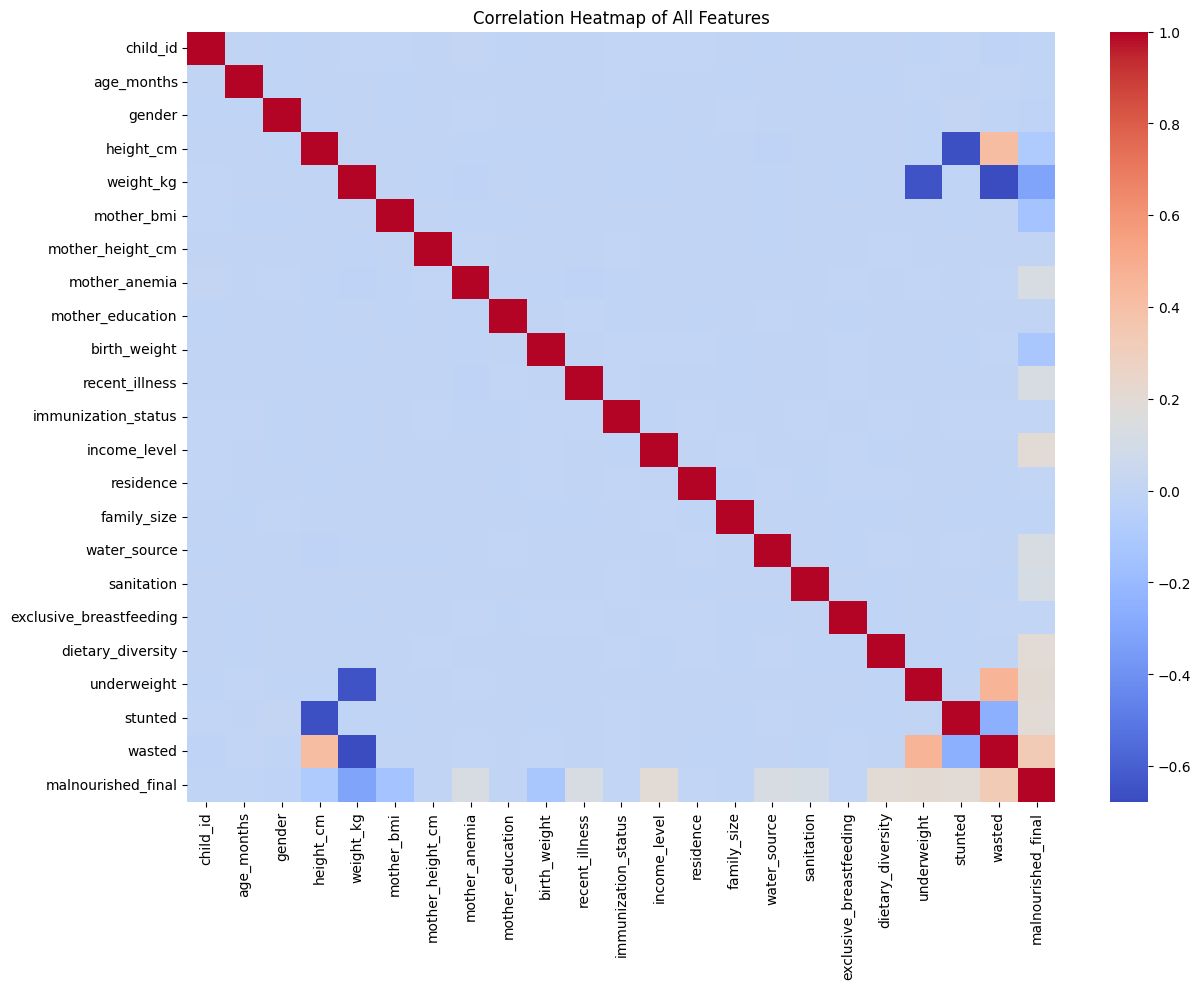

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
corr = df.corr()

sns.heatmap(corr, cmap='coolwarm', annot=False)

plt.title("Correlation Heatmap of All Features")
plt.show()


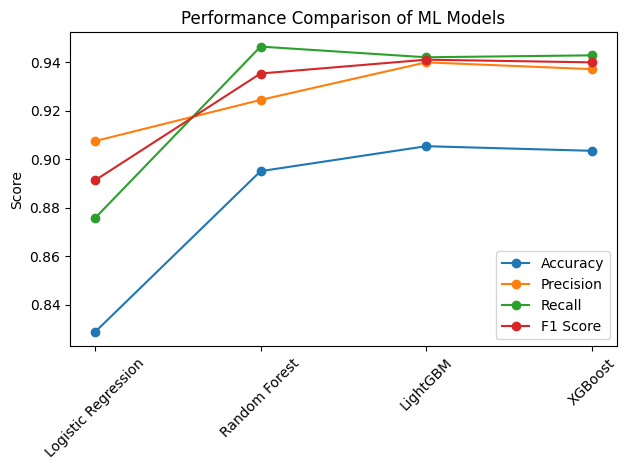

In [25]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

accuracy = [0.8287, 0.8951, 0.9054, 0.9035]
precision = [0.9075, 0.9245, 0.9400, 0.9372]
recall = [0.8757, 0.9465, 0.9421, 0.9429]
f1 = [0.8913, 0.9354, 0.9411, 0.9400]

plt.figure()

plt.plot(models, accuracy, marker='o')
plt.plot(models, precision, marker='o')
plt.plot(models, recall, marker='o')
plt.plot(models, f1, marker='o')

plt.xticks(rotation=45)
plt.ylabel("Score")
plt.title("Performance Comparison of ML Models")
plt.legend(["Accuracy", "Precision", "Recall", "F1 Score"])

plt.tight_layout()
plt.show()
